In [1]:
import networkx as nx

In [64]:
def create_instance_graph(instance):
    DG = nx.DiGraph()
    
    source = (-1, 0)
    sink = (-1, -1)
    jobs_sinks = [ (-1, j) for j in range(instance.n) ]
    
    # Create nodes and edges
    edges_list = []
    nodes_list = [source, sink].extend(jobs_sinks)
    for j in range(instance.n):
        for nb, oper in enumerate(instance.P[j]):
            oper_node = (oper[0], j)
            nodes_list.append(oper_node)
            
            # Add edges
            if nb == 0: # Add source to first job edge
                release_date = instance.R[j] if hasattr(instance, 'R') else 0 
                setup_time = instance.S[oper[0]][j][j] if hasattr(instance, 'S') else 0
                edges_list.append((source, oper_node, release_date + setup_time))
            else: # Add precedence constraints between operations of same job (order between machines)
                edges_list.append( (prev_oper_node, oper_node, oper[1]) )
            
            prev_oper_node = oper_node
        
        # Add last operation to sink edge
        edges_list.append((oper_node, jobs_sinks[j], oper[1]))
        edges_list.append((jobs_sinks[j], sink, 0))
            
    DG.add_nodes_from(nodes_list)
    DG.add_weighted_edges_from(edges_list)
    
    return DG

In [65]:
def create_solution_graph(solution):
    
    # DF contains only conjunctive arcs
    DG = create_instance_graph(solution.instance)
    
    # Add disjunctive arcs according to the schedule
    edges_list = []
    for m_id, machine in enumerate(solution.machines):
        for j_idx, job in enumerate(machine.job_schedule):
            if j_idx != 0: # Add arc between prev_job and current job
                prev_node = (m_id, prev_job.id)
                curr_node = (m_id, job.id)
                
                setup_time = solution.instance.S[m_id][prev_job.id][job.id] \
                    if hasattr(solution.instance, 'S') else 0
                proc_time = [job[1] for job in solution.instance.P[prev_job.id] if job[0] == m_id][0]
                weight = proc_time + setup_time
                
                edges_list.append( ( prev_node, curr_node, weight ) )
            prev_job = job
            
    DG.add_weighted_edges_from(edges_list)
    
    return DG

In [55]:
DG = nx.DiGraph()

DG.add_nodes_from([
    "U", "1,1", "2,1", "2,2", "1,2", "3,3", "3,4", "V"
])

DG.add_weighted_edges_from([
    ("U", "1,1", 0),
    ("U", "2,2", 0),
    ("U", "3,3", 0),
    ("U", "3,4", 0),
    ("1,1", "2,1", -1),
    ("2,2", "1,2", -1),
    ("1,2", "1,1", -1),
    ("2,1", "2,2", 0),
    ("2,1", "V", -1),
    ("1,2", "V", -1),
    ("3,3", "V", -4),
    ("3,4", "V", -4),
    ("3,4", "3,3", 0)
])
labels = nx.get_edge_attributes(DG,'weight')

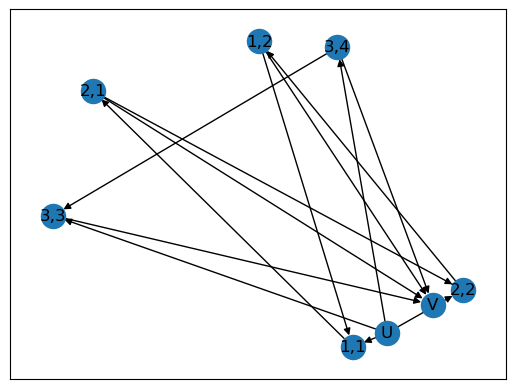

In [56]:
nx.draw_networkx(DG, arrows=True)

In [57]:
nx.is_directed_acyclic_graph(DG)

False

In [59]:
list(nx.simple_cycles(DG))

[['1,2', '1,1', '2,1', '2,2']]

In [58]:
s = nx.single_source_bellman_ford(DG, source="U")

NetworkXUnbounded: Negative cycle detected.

In [52]:
s2 = nx.johnson(DG)

In [53]:
s

({'U': 0,
  '1,1': -2,
  '2,2': 0,
  '3,3': 0,
  '3,4': 0,
  '2,1': -3,
  '1,2': -1,
  'V': -4},
 {'U': ['U'],
  '1,1': ['U', '2,2', '1,2', '1,1'],
  '2,2': ['U', '2,2'],
  '3,3': ['U', '3,3'],
  '3,4': ['U', '3,4'],
  '2,1': ['U', '2,2', '1,2', '1,1', '2,1'],
  '1,2': ['U', '2,2', '1,2'],
  'V': ['U', '3,3', 'V']})

In [54]:
s2

{'U': {'U': ['U'],
  '1,1': ['U', '2,2', '1,2', '1,1'],
  '2,2': ['U', '2,2'],
  '3,3': ['U', '3,3'],
  '3,4': ['U', '3,4'],
  '1,2': ['U', '2,2', '1,2'],
  'V': ['U', '3,3', 'V'],
  '2,1': ['U', '2,2', '1,2', '1,1', '2,1']},
 '1,1': {'1,1': ['1,1'], '2,1': ['1,1', '2,1'], 'V': ['1,1', '2,1', 'V']},
 '2,1': {'2,1': ['2,1'], 'V': ['2,1', 'V']},
 '2,2': {'2,2': ['2,2'],
  '1,2': ['2,2', '1,2'],
  '1,1': ['2,2', '1,2', '1,1'],
  'V': ['2,2', '1,2', '1,1', '2,1', 'V'],
  '2,1': ['2,2', '1,2', '1,1', '2,1']},
 '1,2': {'1,2': ['1,2'],
  '1,1': ['1,2', '1,1'],
  'V': ['1,2', '1,1', '2,1', 'V'],
  '2,1': ['1,2', '1,1', '2,1']},
 '3,3': {'3,3': ['3,3'], 'V': ['3,3', 'V']},
 '3,4': {'3,4': ['3,4'], 'V': ['3,4', 'V'], '3,3': ['3,4', '3,3']},
 'V': {'V': ['V']}}